In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import datetime
from libs.sequences import SeismicSequence
from libs.iris import irisRequests
from libs.distributions import Weibull, WeibullMM, GaussianMM, InterTimeDistribution
from importlib import reload  # Python 3.4+
import matplotlib.pyplot as plt
from ntpp_utils import get_time_nll_loss

In [2]:
def load_hauksson():
    column_names = ["year","month","day", "hour", "minut", 'sec', "id",
                    "lat","lon", "depth", "mag", "nPhases", "azGap", "nearDist", "hErr", "vErr", "residual", "flag1", "flag2"]
    df = pd.read_csv("catalogs/sc_1981_2022q1_1d_3d_gc_soda.gc", sep="\s+", usecols=range(0,11), header=None,names=column_names[:11])
    df['time'] = pd.to_datetime(dict(year=df.year, month=df.month, day=df.day, hours=df.hour, minutes=df.minut, seconds=df.sec))
    return df

# Model

In [3]:
class GRUPointProcess(nn.Module):
    def __init__(self, time_input_dim, time_hidden_dim, time_n_mixtures=1):
        super().__init__()
        self.time_rnn = nn.GRU(time_input_dim,time_hidden_dim,
                          num_layers=1,
                          batch_first=True)
        self.n_mixtures = time_n_mixtures
        if(self.n_mixtures==1):
            self.weibull_mod = nn.Sequential(
                nn.Linear(time_hidden_dim, 2),
                nn.Softplus()
            )
        else:
            self.weibull_mod_b = nn.Sequential(
                nn.Linear(time_hidden_dim, self.n_mixtures),
                nn.Softplus()
            )
            self.weibull_mod_k = nn.Sequential(
                nn.Linear(time_hidden_dim, self.n_mixtures),
                nn.Softplus()
            )
            self.weibull_mixture_mod = nn.Sequential(
                nn.Linear(time_hidden_dim, self.n_mixtures),
                nn.Softmax(dim=-1)
            )
    def forward(self,time_input, features_input=None):
        time_rnn_output, _ = self.time_rnn(time_input) # (n_sequences ~ batch size, max_seq_length, hidden_dim )
        # shift forward along the time dimension and pad
        # so we can use it to model the inter times
        context = F.pad(time_rnn_output[:, :-1, :], (0,0, 1,0))
        
        
        if(self.n_mixtures == 1):
            weibull_params = self.weibull_mod(context)
            distr = Weibull(weibull_params[..., 0], weibull_params[..., 1])
        else:
            weibull_params_b = self.weibull_mod_b(context)
            weibull_params_k = self.weibull_mod_k(context)
            pip_params = self.weibull_mixture_mod(context)
            distr = WeibullMM(pip_params, weibull_params_b,weibull_params_k)
        return context, distr

# Data

In [4]:
region_limits = [29.0, 37.0, -123.0, -112.0 ]
df = load_hauksson()
df.head(5)

,year,month,day,hour,minut,sec,id,lat,lon,depth,mag,time
0,1981,1,1,1,49,29.357,3301561,33.73166,-118.81097,6.399,2.27,1981-01-01 01:49:29.357
1,1981,1,1,4,13,55.936,3301565,33.25355,-115.96716,6.347,2.26,1981-01-01 04:13:55.936
2,1981,1,1,5,20,14.634,3301566,34.18175,-117.30450,5.864,2.37,1981-01-01 05:20:14.634
3,1981,1,1,5,39,56.616,3301567,34.18031,-117.30303,5.991,1.60,1981-01-01 05:39:56.616
4,1981,1,1,8,23,18.236,3301570,34.00782,-117.16284,15.468,1.88,1981-01-01 08:23:18.236


In [5]:
end_date_train = datetime.datetime(2009, 1, 1, 0, 0, 0)
start_date_test = datetime.datetime(2011, 1, 1, 0, 0, 0)
train_sequences = SeismicSequence.from_pandas_df(df[df.time < end_date_train ],
                                                 time_label='time',
                                                 other_labels=['lat','lon', 'mag'],
                                                 unit='D')
test_sequences = SeismicSequence.from_pandas_df(df[df.time >= start_date_test ],
                                                 time_label='time',
                                                 other_labels=['lat','lon', 'mag'],
                                                 unit='D')
val_sequences = SeismicSequence.from_pandas_df(df[(df.time < start_date_test)*(df.time >= end_date_train) ],
                                                 time_label='time',
                                                 other_labels=['lat','lon', 'mag'],
                                                 unit='D')

# Training

In [114]:
model = GRUPointProcess(2, 10, n_mixtures=3)

In [115]:
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [116]:
epochs = 3000
use_random_length = True
duration = 7
loss_hist = []
inter_times = None
period_resample = 5
for epoch in range(epochs):
    print(epoch)
    if(inter_times is None or epoch % period_resample == 0):
        print('Resampling')
        with torch.no_grad():
            seqs = []
            t_start = duration
            max_t_end = train_sequences.t_end
            sequences_durations = []
            while(True):
                if(use_random_length):
                    t_end = t_start + np.random.exponential()*duration
                else:
                    t_end = t_start + duration
                if(t_end > max_t_end):
                    break
                sub_seq = train_sequences.get_subsequence(t_start, t_end)
                if(len(sub_seq.arrival_times) > 0):
                    seqs.append(sub_seq)
                    sequences_durations.append(t_end - t_start)
                t_start = t_end
            sequences_durations = torch.Tensor(sequences_durations)
            inter_times, features, lengths = SeismicSequence.pack_sequences(seqs) 
    optimizer.zero_grad()
    input_time_features = torch.cat([inter_times.unsqueeze(-1), inter_times.clamp_min(1e-8).log().unsqueeze(-1)], dim=-1)
    context, distr = model(input_time_features)
    loss = (get_time_nll_loss(inter_times, lengths, distr)/sequences_durations).mean()
    loss.backward()
    optimizer.step()
    print(loss.item())
    loss_hist.append(loss.item())

0
Resampling
-47.075679779052734
1
-47.85810089111328
2
-48.62316131591797
3
-49.37179183959961
4
-50.10557174682617
5
Resampling
-52.66836166381836
6
-53.40559387207031
7
-54.13516616821289
8
-54.85783386230469
9
-55.574405670166016
10
Resampling
-52.78359603881836
11
-53.447139739990234
12
-54.106056213378906
13
-54.761444091796875
14
-55.414100646972656
15
Resampling
-57.4234504699707
16
-58.08976364135742
17
-58.75532913208008
18
-59.4201545715332
19
-60.08421325683594
20
Resampling
-60.1961669921875
21
-60.84862518310547
22
-61.49955368041992
23
-62.14888381958008
24
-62.79651641845703
25
Resampling
-64.00797271728516
26
-64.65924835205078
27
-65.30873107910156
28
-65.9561767578125
29
-66.60132598876953
30
Resampling
-66.92365264892578
31
-67.55962371826172
32
-68.1922836303711
33
-68.82136535644531
34
-69.44659423828125
35
Resampling
-75.23934173583984
36
-75.88339233398438
37
-76.52396392822266
38
-77.16047668457031
39
-77.79232788085938
40
Resampling
-84.60197448730469
41
-85.2

In [120]:
avg_lh = np.array([temp.mean() for temp in np.split(np.array(loss_hist), len(loss_hist)//period_resample)])

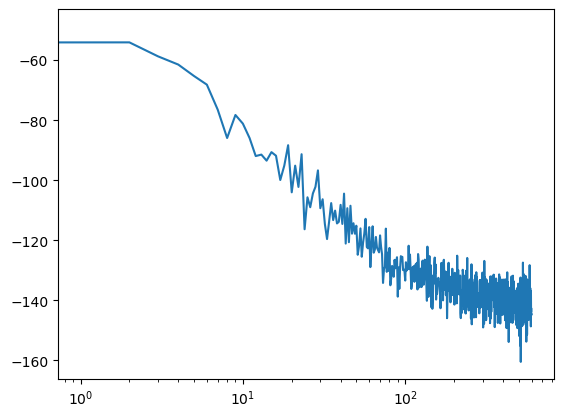

In [130]:
plt.plot(avg_lh)
plt.xscale('log')

In [135]:
with torch.no_grad():
    n_seeds = 150
    n_predictions = 50
    samples = []
    for s in range(300):
        base_inter_times = val_sequences.inter_times[:n_seeds]
        using_inter_times = base_inter_times
        predicted_inter_times = []
        for step in range(n_predictions):
            input_time_features = torch.cat([using_inter_times[None,:,None], using_inter_times[None,:,None].clamp_min(1e-8).log()], dim=-1)
            context, distr = model(input_time_features)
            next_inter_time_b = distr.b[0,-1,:]
            next_inter_time_k = distr.k[0,-1,:]
            next_inter_time_pi = distr.pip[0,-1,:]
            #weibull_index = np.random.choice(next_inter_time_pi, size=1)
            #next_inter_time = (-np.log(1-np.random.uniform(0,1, size=1))/next_inter_time_b[weibull_index])**(1/next_inter_time_k[weibull_index])
            next_inter_time = torch.sum(next_inter_time_pi*(-np.log(1-np.random.uniform(0,1, size=3))/next_inter_time_b)**(1/next_inter_time_k))
            predicted_inter_times.append(next_inter_time)
            using_inter_times = torch.cat([using_inter_times,torch.tensor([next_inter_time]) ]).type(torch.float32)
        samples.append(using_inter_times[None,:])
    samples = torch.cat(samples, dim=0)

(2.0, 6.0)

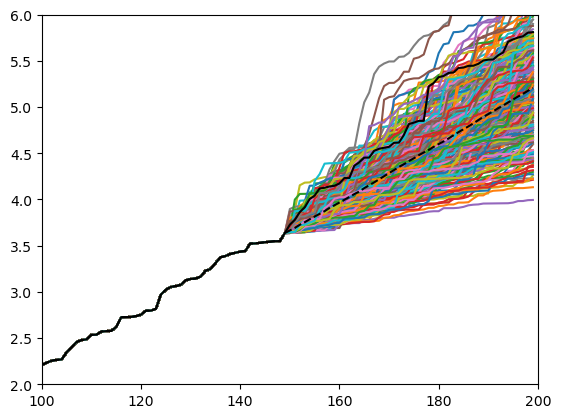

In [136]:
for sample in samples:
    plt.plot(np.cumsum(sample))
plt.plot(np.cumsum(val_sequences.inter_times[:n_seeds+n_predictions]), color='black')
plt.plot(np.cumsum(samples, axis=1).mean(axis=0), color='black', ls='dashed')
plt.xlim(n_seeds-50, n_seeds+n_predictions)
plt.ylim(2,6)